# Жидкокристаллический двигатель

В работе "Синтетический «демон» Максвелла", опубликованной в журнале «Химия и жизнь», 2001, №12 (http://daju.narod.ru/Maxwell/SintMaxwDem.htm) мною была сформулирована следующая идея: "для реализации идеи Максвелла ... нужно создать такую молекулярную систему, в которой пространственные затруднения для теплового движения молекул рабочей жидкости в одном направлении были бы меньшими, чем в противоположном."

Данную идею я пытался реализовать в следующих работах: 

- "Жидкокристаллический двигатель или акустомеханический преобразователь", 4-6 января 2010 г – 17 июля 2010 г., http://liquidcrystalosmos.narod.ru/liquidcrystalengine.htm

- Жидкокристаллический двигатель, доработанный вариант
6-29 Jun 2023
https://github.com/daju1/articles/blob/master/liquidcrystalengine/liquidcrystalengine.doc

- Жидкокристаллический осмос или о возможности нарушения принципа детального равновесия в жидкокристаллической дисклинации, 17.11.2010, http://liquidcrystalosmos.narod.ru/liquidcrystalosmos.htm

- Жидкокристаллический осмос или о возможности нарушения принципа детального равновесия в жидкокристаллической дисклинации, переработанный и исправленный вариант, Dec 15, 2022,  https://nbviewer.org/github/daju1/articles/blob/master/liquidcrystalosmos/liquidcrystalosmos.ipynb

- Геометрический диод для молекул, https://nbviewer.org/github/daju1/articles/blob/master/diode_for_molecules/diode_for_molecules.ipynb

В данном рачёте была использована специально сформированная молекулярная система для задания необходимой ориентации нематика путём закрепления молекул ориентантов на графитоподобной матрице. Причём благодаря периодическим условиям графитоподобная матрица может свободно двигаться в направлении X.

Причем, с учётом того, что таких матриц использовалось две (верхняя и нижняя лента), фактически был промоделирован ротор и статор жидкокристаллического двигателя.

Ориентирующие ленты имеют атомы углерода, к которым прикреплены молекулы ориентанты. Связь этих атомов с другими атомами ленты построена таким образом, чтобы молекулы ориентанты получили наклон близкий к 45 градусов.

Две таких ленты были добавлены в ячейку к 28-ми молекулам 5ЦБ

На оси x были заданы периодические граничные условия. Это значит, что если атом вылетел за пределы границы расчётной ячейки, перпендикулярной оси x, то считается что он залетел с той же скоростью но с противоположной стороны.

А на осях y, z был использован wall boundary potential, моделирующий твёрдые стенки на границах ячейки, перпендикулярных этим осям

Исходные файлы для моделирования доступны здесь
https://github.com/daju1/moldyn/blob/main/laboro/new_LC/5CB/28i2lenty_wbp_yz/

![28i2lenty_wbp_yz.png](../28i2lenty_wbp_yz.png)


исходные коды программы ghemical, которую я использую для МД моделирования, взяты отсюда
https://www.bioinformatics.org/ghemical/download/release20111012/

Но в целях проведения эксперимента данные коды были модифицированы набором патчей

https://github.com/daju1/winlibghemical/tree/master/linux/release20111012

который в среде докер 

https://github.com/daju1/winlibghemical/tree/master/linux/release20111012/docker

собираются следующим набором комманд

	make download
	make getcodes
	make all

Был разработаны также и рабочий пример для запуска моделирования из консольной программы без визуального интерфейса

https://github.com/daju1/winlibghemical/blob/master/linux/release20111012/examples/example_moldyn.cpp

А непосредственно для запуска моделирования использовался скрипт на основе

https://github.com/daju1/winlibghemical/blob/master/linux/release20111012/examples/example_moldyn.01.sh


В алгоритм программы МД закладываются потенциалы взаимодействия атомов друг с другом, в частности

https://ru.wikipedia.org/wiki/Потенциал_Леннард-Джонса

В программе, которую использовал я, используется

http://open-babel.readthedocs.io/en/latest/Forcefields/ghemical.html


# опции алгоритма МД

B0, B1, B2 в названии файла означает режим оптимизации размера бокса во время процесса МД

B0 - отсутствует оптимизация размера бокса вообще

B1 - оптимизация размера бокса включена постоянно. Этот режим также был включён по умолчанию ранее в предыдущих моделированиях а также в файлах тракторий с отсутствующей буквой B

B2 - только лишь в процессе нагревания и уравновешивания

	enum box_optimization_moldyn_mode
	{
		box_optimization_no = 0,
		box_optimization_always,
		box_optimization_equilibration, // box_optimization just during heating and equilibration
	};

E - алгоритм термостата выключен, моделирование при постоянной энергии

I - инверсия скоростей инициализации начальных скоростей атомов

Для презентации результатов моделирования использую следующие функции

# Функция расчёта мощности процесса

In [1]:
def calc_power(this_is_a_lenta):
    global header
    global data
    global boundary

    import numpy as np
 
    start_from = int(0.9 * len(data[0]))
    print("start_from", start_from)
    i_cumulative_mean_velocity_m_s = 21
    i_cumulative_mean_force        = 22
    data_cumulative_mean_velocity_m_s = data[i_cumulative_mean_velocity_m_s][start_from:]
    data_cumulative_mean_force        = data[i_cumulative_mean_force       ][start_from:]
    
    cumulative_mean_velocity_m_s =  np.mean(data_cumulative_mean_velocity_m_s)
    # внутрипрограмный параметр "сила" (eng->d1) противонаправлен ускорению.
    # Поэтому действительная сила имеет противоположный знак внутрипрограммному параметру "сила"
    cumulative_mean_force        = -np.mean(data_cumulative_mean_force)
    
    print(header[i_cumulative_mean_velocity_m_s] , "=", cumulative_mean_velocity_m_s)
    print(header[i_cumulative_mean_force       ], "   =", cumulative_mean_force)
    
    # metr^2
    s_m_2 = 4*boundary[0]*boundary[2]*(10^-9)^2
    p_ed_izm_Pa_per_atom_ = F_ed_izm_Newton_per_atom / s_m_2
    
    p_os = cumulative_mean_force * p_ed_izm_Pa_per_atom_
    print("p_os, Pascal                 =", p_os)
    V_os = cumulative_mean_velocity_m_s
    print("V_os, m/s                    =", V_os)
    
    if (this_is_a_lenta):
        power = 0.5 * p_os * V_os
        print("power, Watt/m^2              =", power)

# Функция загрузки данных моделирования из файла

In [2]:
def fill_data_from_file(fn, print_header = False):
    global header
    global data
    global boundary
    with open(fn) as file:
        while line := file.readline():
            if line.__contains__("the trajectory common time is"):
                print(line)
            lst = line.split(",")
            if len(lst) < 3:
                lst = line.split(" ")
                if len(lst) == 4 and lst[0] == 'boundary':
                    boundary[0] = float(lst[1])
                    boundary[1] = float(lst[2])
                    boundary[2] = float(lst[3])
                    print ("boundary", boundary)
                continue

            if (None == header):
                header = lst
                header_len = len(header)
                if print_header:
                    print(header)
                for i in range(header_len):
                    data += [[]]
            else:
                for i in range(header_len):
                    value = float(lst[i])
                    data[i] += [value]

универсальная газовая постоянная = 8.31446262 $Дж\, К^{-1} Моль^{-1}$

$N_A$ ≡ 6,022 140 76 10^23 $моль^{−1}$

In [3]:
R          = 8.31446262
N_Avogadro = 6.02214076 * 10^23
T          = 300

Анализируя внутрипрограммные формулы можно заметить, что второй закон Ньютона записан в виде $F = -\,m \cdot a$. Подставляя использованные в программе единицы измерения

$[F] = [kg/mol] \cdot [1.0e+12\,m/s^2]$

$[F] = [1.0e+12\,Newton/mol]$

$[F] = [1.66053906717385e-12\,Newton/atom]$

Коеффициент перевода единиц силы из внутрипрограмных единиц в Ньютон на атом

In [4]:
F_ed_izm_Newton_per_mol = 1.0e+12
F_ed_izm_Newton_per_atom = F_ed_izm_Newton_per_mol/N_Avogadro
F_ed_izm_Newton_per_atom

1.66053906717385e-12

In [5]:
boundary = [0, 0, 0]

In [6]:
295-273

22

In [7]:
folder = "."
fn = "28i2lenty_295_H_P"
dim = "0"

# Результат моделирования 295 K H P

результат моделирования со следующими опциями

- оптимизация размера XY бокса - off (B0)
- функция термостата включена, используется термостат Nose Hoover (H)
- для моделирования при постоянном давлении используется функция баростата Берендсена (P)
- инициализация начальных скоростей атомов производилась для температуры 295 К

# Визуализация результатов, усреднённых по ленте номер 0 (верхней ленте)

In [8]:
header = None
data = []
fill_data_from_file(folder + "/" + fn + ".traj.plots.dim"+dim+".lenta_number_0.txt")

calc_power(this_is_a_lenta = True)

the trajectory common time is 60.64 * 1.0E-9 s

boundary [1.79708, 2.20031, 0.36072]
start_from 5459
cumulative_mean_velocity(m/s) = 0.18776987808896212
cumulative_mean_force    = 0.005858076721581548
p_os, Pascal                 = 3751.513627034435
V_os, m/s                    = 0.18776987808896212
power, Watt/m^2              = 352.21062819866796


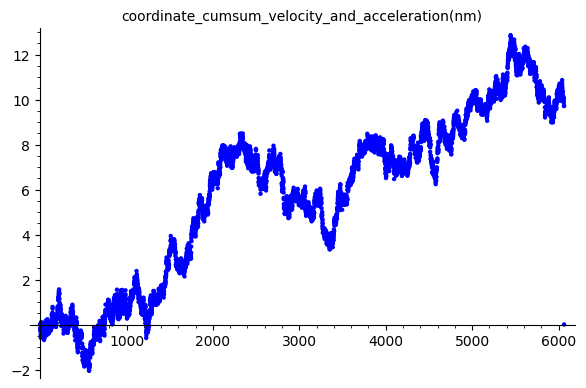

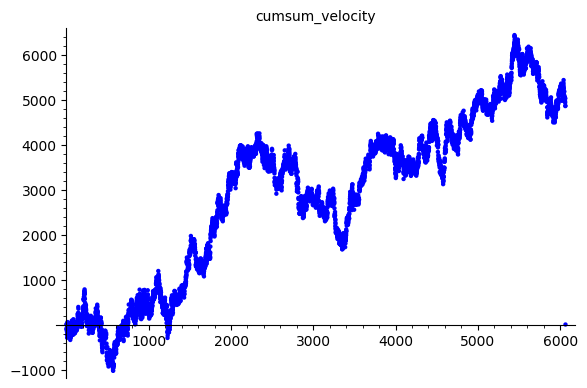

In [9]:
for i in [20, 9]:
    plt = list_plot(data[i])
    plt.show(title=header[i])

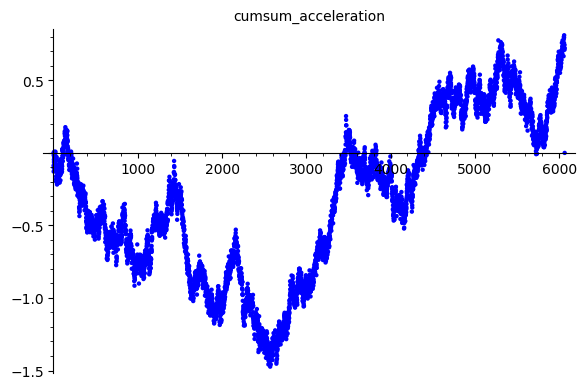

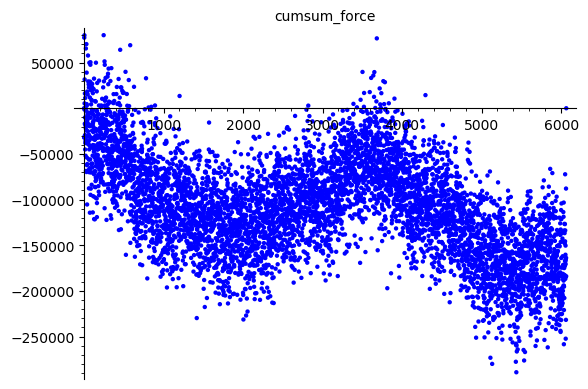

In [10]:
for i in [10, 11]:
    plt = list_plot(data[i])
    plt.show(title=header[i])

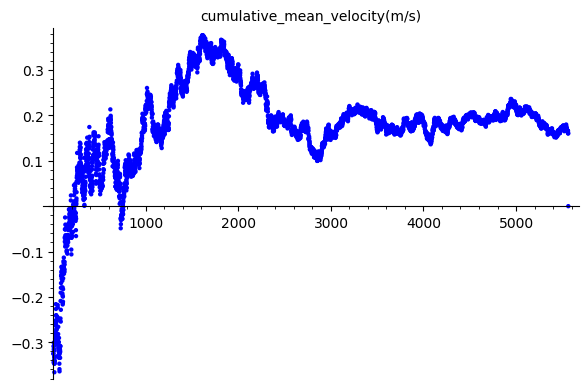

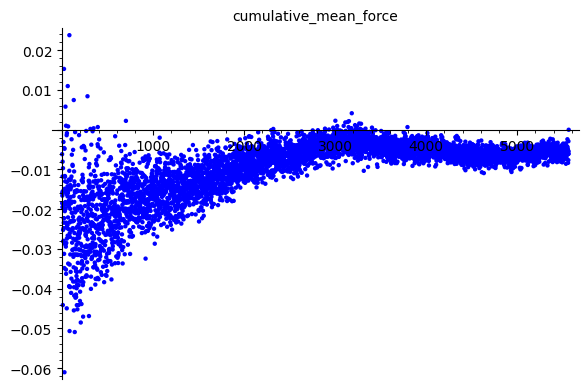

In [11]:
start_from = 500
for i in [21, 22]:
    plt = list_plot(data[i][start_from:])
    plt.show(title=header[i])

# Визуализация результатов, усреднённых по ленте номер 1 (нижней ленте)

In [12]:
header = None
data = []
fill_data_from_file(folder + "/" + fn + ".traj.plots.dim"+dim+".lenta_number_1.txt")
calc_power(this_is_a_lenta = True)

the trajectory common time is 60.64 * 1.0E-9 s

boundary [1.79708, 2.20031, 0.36072]
start_from 5459
cumulative_mean_velocity(m/s) = -0.24077560790774302
cumulative_mean_force    = -0.011624194645799012
p_os, Pascal                 = -7444.136819915607
V_os, m/s                    = -0.24077560790774302
power, Watt/m^2              = 896.1832840817966


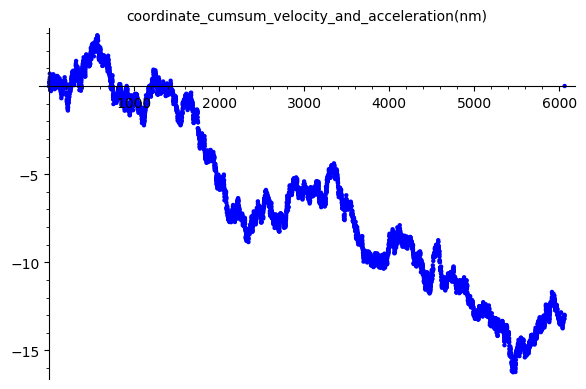

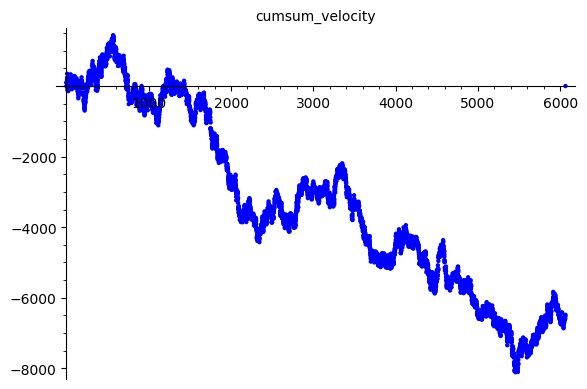

In [13]:
for i in [20, 9]:
    plt = list_plot(data[i])
    plt.show(title=header[i])

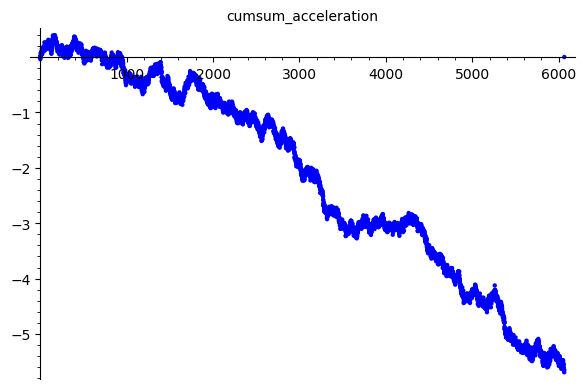

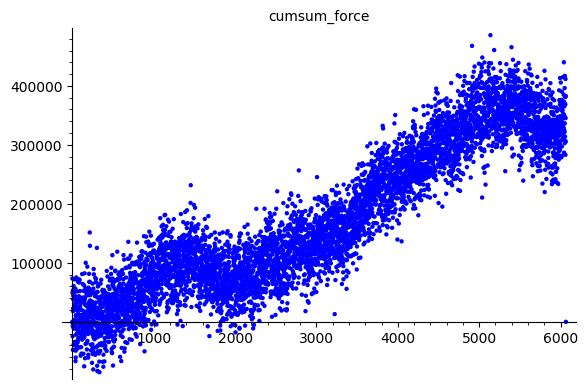

In [14]:
for i in [10, 11]:
    plt = list_plot(data[i])
    plt.show(title=header[i])

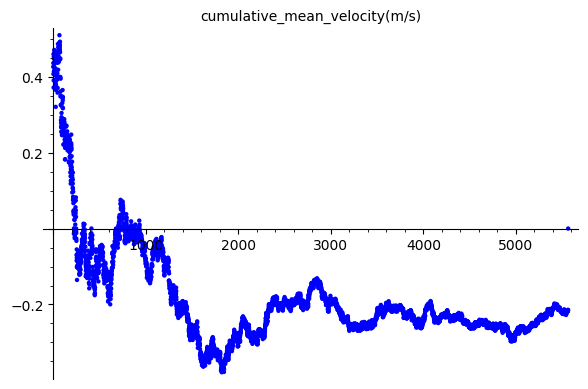

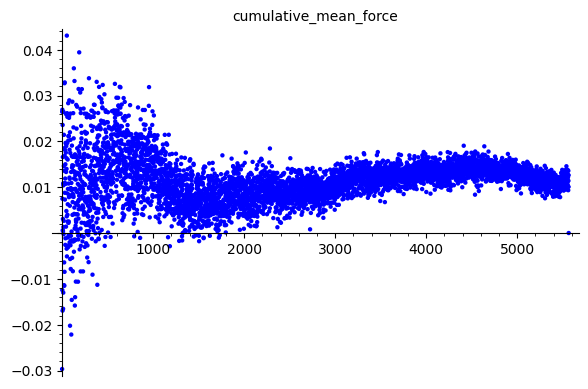

In [15]:
start_from = 500
for i in [21, 22]:
    plt = list_plot(data[i][start_from:])
    plt.show(title=header[i])

# Результат моделирования 295 K, H P I

результат моделирования со следующими опциями

- оптимизация размера XY бокса - off (B0)
- функция термостата включена, используется термостат Nose Hoover (H)
- для моделирования при постоянном давлении используется функция баростата Берендсена (P)
- инициализация начальных скоростей атомов производилась для температуры 295 К
- инверсия скоростей инициализации начальных скоростей атомов (I)

# Визуализация результатов, усреднённых по ленте номер 0 (верхней ленте)

In [16]:
header = None
data = []
fill_data_from_file(folder + "/" + fn + "_I.traj.plots.dim"+dim+".lenta_number_0.txt")
calc_power(this_is_a_lenta = True)

the trajectory common time is 60.29 * 1.0E-9 s

boundary [1.79708, 2.20031, 0.36072]
start_from 5427
cumulative_mean_velocity(m/s) = -0.02545849318874172
cumulative_mean_force    = 0.0032109955526490068
p_os, Pascal                 = 2056.3222614908914
V_os, m/s                    = -0.02545849318874172
power, Watt/m^2              = -26.17543314401191


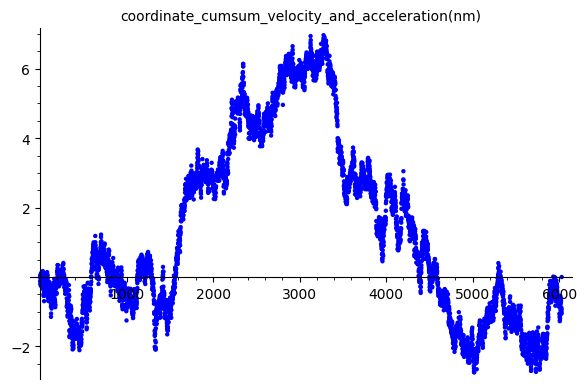

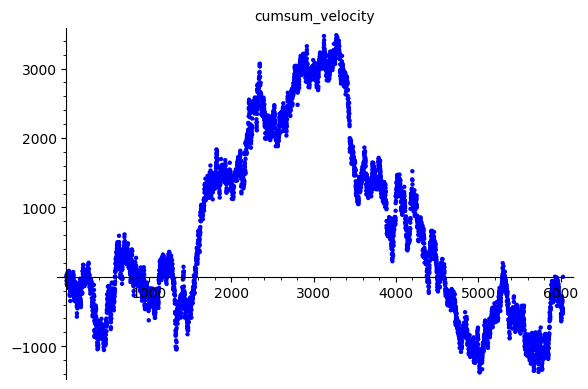

In [17]:
for i in [20, 9]:
    plt = list_plot(data[i])
    plt.show(title=header[i])

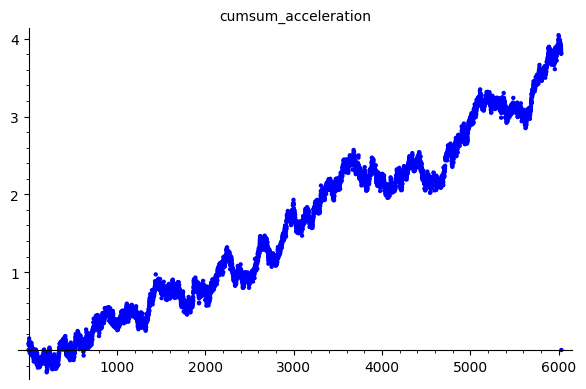

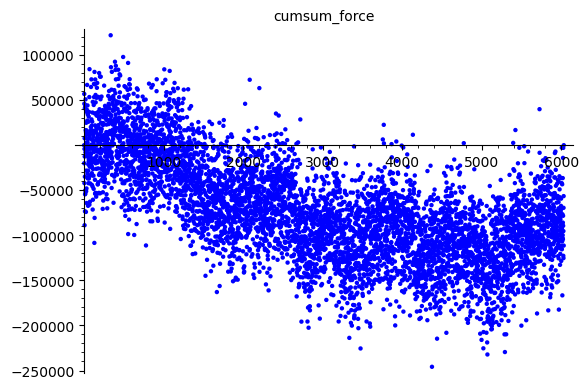

In [18]:
for i in [10, 11]:
    plt = list_plot(data[i])
    plt.show(title=header[i])

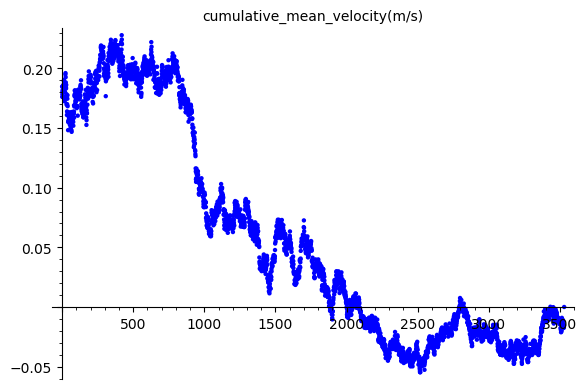

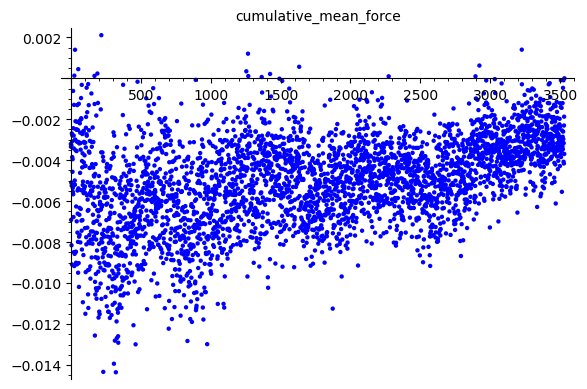

In [19]:
start_from = 2500
for i in [21, 22]:
    plt = list_plot(data[i][start_from:])
    plt.show(title=header[i])

# Визуализация результатов, усреднённых по ленте номер 1 (нижней ленте)

In [20]:
header = None
data = []
fill_data_from_file(folder + "/" + fn + "_I.traj.plots.dim"+dim+".lenta_number_1.txt")
calc_power(this_is_a_lenta = True)

the trajectory common time is 60.29 * 1.0E-9 s

boundary [1.79708, 2.20031, 0.36072]
start_from 5427
cumulative_mean_velocity(m/s) = 0.022292684321192056
cumulative_mean_force    = -0.005701623509933775
p_os, Pascal                 = -3651.320955721748
V_os, m/s                    = 0.022292684321192056
power, Watt/m^2              = -40.698872710629104


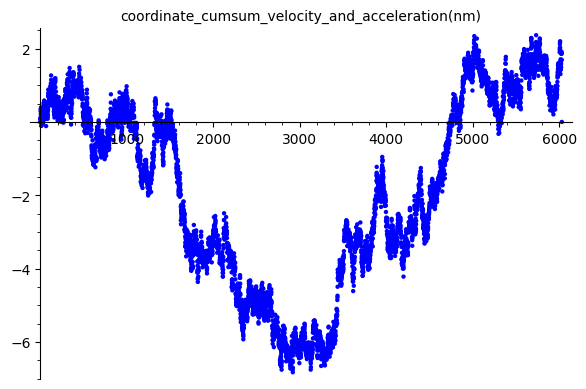

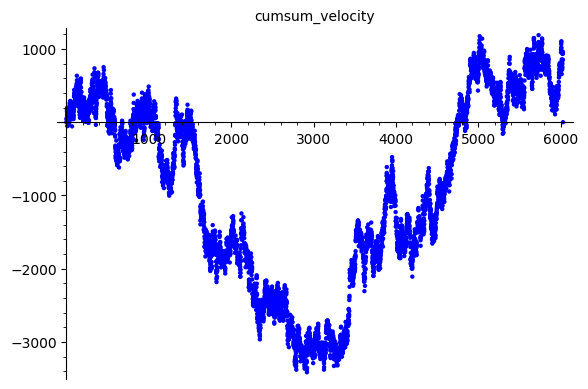

In [21]:
for i in [20, 9]:
    plt = list_plot(data[i])
    plt.show(title=header[i])

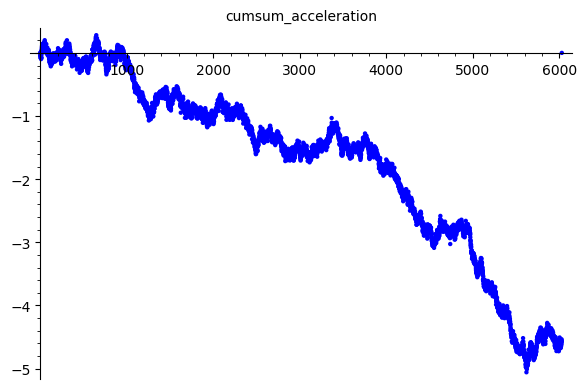

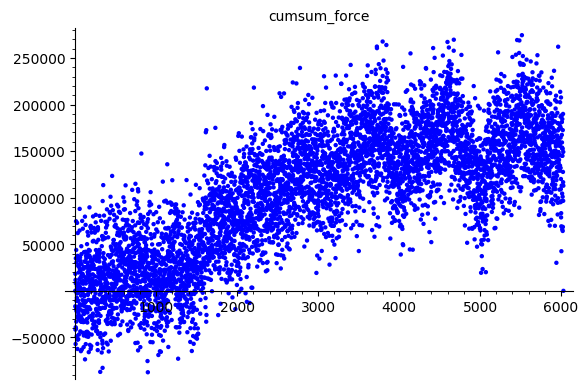

In [22]:
for i in [10, 11]:
    plt = list_plot(data[i])
    plt.show(title=header[i])

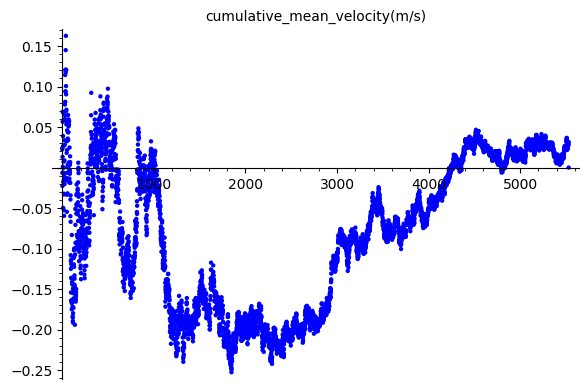

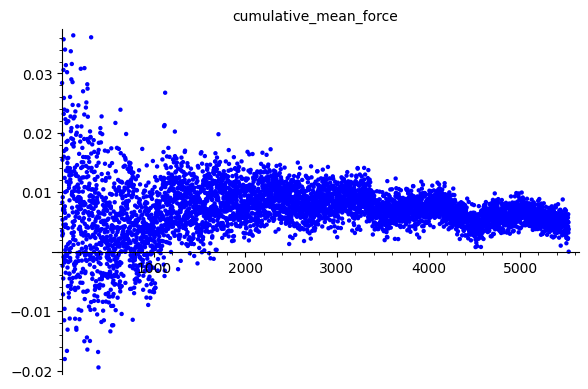

In [23]:
start_from = 500
for i in [21, 22]:
    plt = list_plot(data[i][start_from:])
    plt.show(title=header[i])

# Предварительные выводы

полученные в данном расчете внушают оптимизм. Поскольку оценка удельной мощности для жидкокристаллического двигателя составляет порядка 100 ватт на квадратный метр, если суммировать мощность выделяемую на нижней и верхней ленте.

По сравнению с жидкокристаллическим осмосом с его 10 милливаттами на квадратный метр это весьма хороший прогноз, обусловленной тем что в жидкокристаллическом осмосе лимитирующим фактором является низкий коэффициент диффузии нематика в порах пористого стекла 

А в жидкокристаллическом двигателе работает вся поверхность ленты.

Направление дрейфа верхней и нижней лент соответствует, направлению, ожидаемому в работе Жидкокристаллический двигатель. Более того, в той же работе было указано, что согласно анализа результатов моделирования февраля 2010 года относительная скорость движения лент друг относительно друга может составить около 10 сантиметров в секунду.

В текущем же расчёте относительная скорость направленного броуновского дрейфа лент того же порядка, а именно: 6.79 и 10.64 сантиметров в секунду.

Есть веские основания полагать, что важную роль в полученном результате сыграл такой параметр моделирования, как баростат Берендсена, действие которого похоже на действие длинноволновых тепловых фононов, упоминающихся в теории теплоемкости. С учетом того, что размер ячейки моделирования много меньше реального размера исследуемой системы, содержащей фононы теплоемкости, по сути баростат Берендсена выполнял роль флуктуаций плотности под действием длинноволновых тепловых фононов